In [1]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [93]:
def softmax_forward(X):
#     eX = np.exp((X.T - np.max(X, axis=1)).T) # X_txn
    eX = np.exp((X.T - X.max(axis=1)).T) # X_txn
    out = (eX.T / eX.sum(axis=1)).T
    cache = out
    return out, cache

# # def softmax(self, x):
# #     """Compute the softmax of vector x."""
# #     exps = np.exp(x)
# #     return exps / np.sum(exps)

# # # np.exp is not stable because it has Inf. 
# # # So you should subtract maximum in x.
# # def softmax(x):
# #     """Compute the softmax of vector x."""
# #     exps = np.exp(x - x.max())
# #     return exps / np.sum(exps)

# def softmax_forward(X):
#     # self.input is a vector of length 10
#     # X_1xn, n=10
#     eX = np.exp((X.T - X.max(axis=1).T) # X_txn
#     out = (eX.T / eX.sum(axis=1)).T
#     cache = X
#     return out, cache

# # def softmax_backward2(self):
# #     for i in range(len(self.value)):
# #         for j in range(len(self.input)):
# # #             if i == j:
# # #                 self.gradient[i] = self.value[i] * (1-self.input[i))
# # #             else: 
# # #                  self.gradient[i] = -self.value[i]*self.input[j]
# #             if i == j:
# #                 self.gradient[i,j] = self.value[i] * (1-self.values[i])
# #             else: 
# #                 self.gradient[i,j] = self.value[i] * (-self.values[j])
# #     return self.gradient

def softmax_backward(dout, cache):
    out = cache
    grads = []
    for idx in range(out.shape[0]):
        SM = out[idx].reshape((-1,1)) # each_nx1
        jac = np.diag(out[idx]) - np.dot(SM, SM.T) # jac_nxn
        grad = dout[idx].reshape(1, -1) @ jac # grad_1xn
        grads.append(grad)
    grads = np.array(grads, dtype=float).reshape(out.shape)
#     print(grads.shape)
#     print(np.diag(out[idx]).shape, np.diag(out[idx])) # last idx
    return grads

In [94]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # num layers
        self.C = C # num classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.grads = []
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        dX = dout @ W.T # vanilla Backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
#         y = l.softmax(X=y)
        y, nl_cache = softmax_forward(X=y)
        if train:
            caches.append((fc_cache, nl_cache))

        return y, caches # for backpropating the error

    def onehot(self, labels):
#         y = np.zeros([labels.size, np.max(labels) + 1])
        y = np.zeros([labels.size, self.C])
        y[range(labels.size), labels] = 1.
        return y

    def squared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]

#         data_loss = 0.5 * np.sum((y_pred - self.onehot(y_train))**2)/ m
#         data_loss = 0.5 * np.sum((y_pred + self.onehot(y_train))**2)/ m
        data_loss = 0.5 * np.sum((y_pred + (0.5 * self.onehot(y_train)))**2)/ m

        return data_loss

    def dsquared_loss(self, y_pred, y_train):
        m = y_pred.shape[0]

#         grad_y = (y_pred - self.onehot(y_train))/ m
#         grad_y = (y_pred + self.onehot(y_train))/ m
        grad_y = (y_pred + (0.5 * self.onehot(y_train)))/ m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.squared_loss(y_pred=y_prob, y_train=y_train)
        dy = self.dsquared_loss(y_pred=y_prob, y_train=y_train)
        
        return loss, dy
        
    def train_backward(self, dy, caches):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
        
        # Output layer
        fc_cache, nl_cache = caches[2]
        # softmax_backward ???????
#         dy = softmax_backward(cache=nl_cache, dout=dy)
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        dy = dX.copy()
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer])
            dy = dX.copy()
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
        _, dW, db = self.fc_backward(dout=dy, cache=fc_cache)
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            grads = self.train_backward(dy, caches)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [95]:
# Hyper-parameters
n_iter = 1000 # number of epochs
alpha = 1e-2 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-0.2245, acc-0.0800, valid loss-0.2249, acc-0.0850, test loss-0.2251, acc-0.0935
Iter-20, train loss-0.2244, acc-0.0800, valid loss-0.2242, acc-0.0640, test loss-0.2243, acc-0.0678
Iter-30, train loss-0.2221, acc-0.0600, valid loss-0.2235, acc-0.0434, test loss-0.2236, acc-0.0474
Iter-40, train loss-0.2234, acc-0.0400, valid loss-0.2228, acc-0.0356, test loss-0.2229, acc-0.0357
Iter-50, train loss-0.2223, acc-0.0200, valid loss-0.2222, acc-0.0312, test loss-0.2223, acc-0.0290
Iter-60, train loss-0.2218, acc-0.0200, valid loss-0.2216, acc-0.0262, test loss-0.2217, acc-0.0221
Iter-70, train loss-0.2215, acc-0.0200, valid loss-0.2211, acc-0.0210, test loss-0.2211, acc-0.0174
Iter-80, train loss-0.2204, acc-0.0000, valid loss-0.2206, acc-0.0174, test loss-0.2206, acc-0.0125
Iter-90, train loss-0.2207, acc-0.0400, valid loss-0.2201, acc-0.0142, test loss-0.2201, acc-0.0093
Iter-100, train loss-0.2210, acc-0.0000, valid loss-0.2197, acc-0.0134, test loss-0.2197, acc-0.0079

Iter-830, train loss-0.2247, acc-0.0400, valid loss-0.2250, acc-0.0958, test loss-0.2250, acc-0.0980
Iter-840, train loss-0.2248, acc-0.0400, valid loss-0.2250, acc-0.1070, test loss-0.2250, acc-0.0982
Iter-850, train loss-0.2253, acc-0.1400, valid loss-0.2250, acc-0.0868, test loss-0.2250, acc-0.0892
Iter-860, train loss-0.2247, acc-0.0600, valid loss-0.2250, acc-0.1070, test loss-0.2250, acc-0.0982
Iter-870, train loss-0.2246, acc-0.0800, valid loss-0.2250, acc-0.1070, test loss-0.2250, acc-0.0982
Iter-880, train loss-0.2244, acc-0.0600, valid loss-0.2250, acc-0.0866, test loss-0.2250, acc-0.0888
Iter-890, train loss-0.2248, acc-0.0400, valid loss-0.2250, acc-0.1070, test loss-0.2250, acc-0.0982
Iter-900, train loss-0.2251, acc-0.0800, valid loss-0.2250, acc-0.0958, test loss-0.2250, acc-0.0980
Iter-910, train loss-0.2250, acc-0.0600, valid loss-0.2250, acc-0.0868, test loss-0.2250, acc-0.0892
Iter-920, train loss-0.2250, acc-0.1600, valid loss-0.2250, acc-0.0958, test loss-0.2250, a

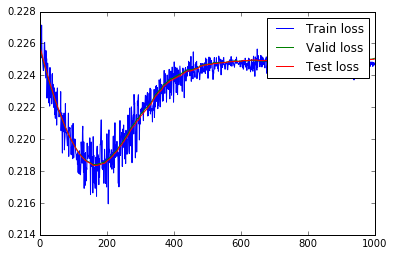

In [96]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

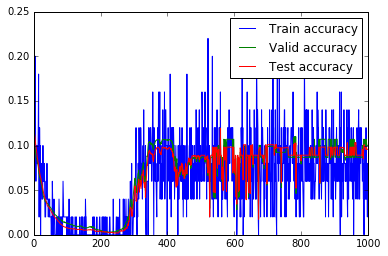

In [97]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()